# get annotations - sentences

In [1]:
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans
from pprint import pprint

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [2]:
from bert_serving.client import BertClient
bc = BertClient()

# load dataset with encodings

In [3]:
dataset_path2 = Path('../../data')

In [4]:
annotations_df2 = pd.read_pickle(str(dataset_path2/'annotations.pkl'))

In [5]:
ann_df = annotations_df2.iloc[:1000]

In [6]:
ann_df

,sample_id,annotation,encoding
0,1,A person is walking forwards.,"[-0.15791105, -0.016321294, -0.018729901, -0.4..."
1,2,A person walks 4 steps forward.,"[-0.1540823, -0.13345166, 0.07930961, -0.23958..."
2,3,A human walking,"[-0.14400074, -0.495848, -0.48444295, 0.011635..."
3,4,A person walks forward at medium speed.,"[-0.21677037, -0.22117159, 0.023956455, -0.338..."
4,4,human slowly goes forward,"[-0.58368725, -0.18312697, 0.29863808, -0.1279..."
...,...,...,...
995,422,A person walks and turns 90 degrees to the right.,"[-0.11423552, -0.1854339, 0.023233175, -0.1367..."
996,422,A human is walking in a 90° right curve,"[-0.254665, -0.18984391, 0.14303024, -0.272296..."
997,423,A human turning right,"[-0.6380227, -0.3515872, -0.09110657, 0.084793..."
998,424,a person walks slowly forward,"[-0.31345516, -0.17276967, -0.039439354, -0.26..."


# do clustering

In [7]:
X = np.stack(ann_df.encoding.to_numpy(), axis=0)
X.shape

(1000, 768)

# TODO: specify some clusters manually

In [8]:
true_k = 10
kmeans = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=10, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [9]:
clusters = kmeans.labels_.tolist()
len(clusters)

1000

# analyze/visualize clusters

In [10]:
Y_df = ann_df
Y = X

In [11]:
prediction = kmeans.predict(Y)
print(prediction[:10])

ann_df['pred'] = prediction

[9 2 9 2 9 2 2 5 2 2]


/Users/wcz/opt/anaconda3/envs/labx/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
Y_anns = Y_df.annotation.to_list(); Y_anns[:5]

['A person is walking forwards.',
 'A person walks 4 steps forward.',
 'A human walking',
 'A person walks forward at medium speed.',
 'human slowly goes forward']

In [13]:
preds = [(ann, prediction[idx]) for idx, ann in enumerate(Y_anns)]; preds[:5]

[('A person is walking forwards.', 9),
 ('A person walks 4 steps forward.', 2),
 ('A human walking', 9),
 ('A person walks forward at medium speed.', 2),
 ('human slowly goes forward', 9)]

In [14]:
for x in range(1, true_k+1):
    pprint([p for p in preds if p[1]==x][:20])
    print()

[('Someone walks in a circle counterclockwise', 1),
 ('Somebody wals a circle anticlockwise.', 1),
 ('Someone walks in a circle counterclockwise', 1),
 ('A perons walks a circle clockwise', 1),
 ('human walks in a quater circle clockwise', 1),
 ('human goes in a circle counterclockwise', 1),
 ('A human walking in a circle counterclockwise', 1),
 ('A person walks in a circle counterclockwise.', 1),
 ('A human walks in circle counterclockwise.', 1),
 ('A human walking in a circle counterclockwise', 1),
 ('human goes in a circle counterclockwise', 1),
 ('someone walks a anticlockwise.', 1),
 ('A person walks a circle, radius approximatly 1,5 m', 1),
 ('A person walks a right sided circle, radius approximatly 50cm', 1),
 ('Subject walks in a quarter circle counterclockwise.', 1),
 ('Somebody walks a quarter circle anticlockwise.', 1),
 ('Subject walks in a quarter circle counterclockwise.', 1),
 ('human goes in a quater circle counterclockwise starting with left', 1),
 ('human goes in a qu

# T-SNE

# reduce dimensionality

In [15]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)
tsne_df = tsne.fit_transform(X[:])

In [16]:
tsne_df[:10]

array([[  8.960277  ,  -9.868182  ],
       [ 18.071344  ,  -3.4603627 ],
       [  3.352975  , -12.772672  ],
       [ 12.803798  ,  -7.180764  ],
       [  4.030066  , -17.848545  ],
       [ 14.841574  ,  -4.8232746 ],
       [ 15.539987  ,  -7.7542267 ],
       [ -2.8605978 ,  17.66786   ],
       [ 14.290997  ,  -0.99150276],
       [ 20.069141  ,  -2.7604966 ]], dtype=float32)

In [17]:
# visualize

In [18]:
# pick, and refine centroids/classes

In [19]:
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
centroids.shape

(10, 768)

In [20]:
X.shape

(1000, 768)

# append centroids, and then separate them

In [21]:
Xprim = np.concatenate([X, centroids], axis=0)
Xprim.shape

(1010, 768)

In [22]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_prim = tsne.fit_transform(Xprim[:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1010 samples in 0.031s...
[t-SNE] Computed neighbors for 1010 samples in 1.250s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1010
[t-SNE] Computed conditional probabilities for sample 1010 / 1010
[t-SNE] Mean sigma: 2.630900
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.158180
[t-SNE] KL divergence after 300 iterations: 0.753519
t-SNE done! Time elapsed: 2.1656789779663086 seconds


In [23]:
tsne_results = tsne_results_prim[:X.shape[0], :]
centroids_results = tsne_results_prim[X.shape[0]:, :]
tsne_results.shape, centroids_results.shape

((1000, 2), (10, 2))

In [24]:
df2 = pd.DataFrame({'pred': list(range(true_k))})
df2['tsne-2d-one'] = centroids_results[:,0]
df2['tsne-2d-two'] = centroids_results[:,1]
df2['size'] = 20#df2.pred*10
df2

,pred,tsne-2d-one,tsne-2d-two,size
0,0,1.447170,-0.407855,20
1,1,17.438700,7.776448,20
2,2,-46.917980,9.222116,20
3,3,9.146831,-1.822211,20
4,4,9.185188,-5.039758,20
5,5,5.882145,-11.538810,20
6,6,8.663497,-0.150193,20
7,7,-5.280010,-11.398961,20
8,8,4.980959,11.441653,20
9,9,-12.617997,2.201363,20


In [25]:
df_subset = ann_df.copy()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

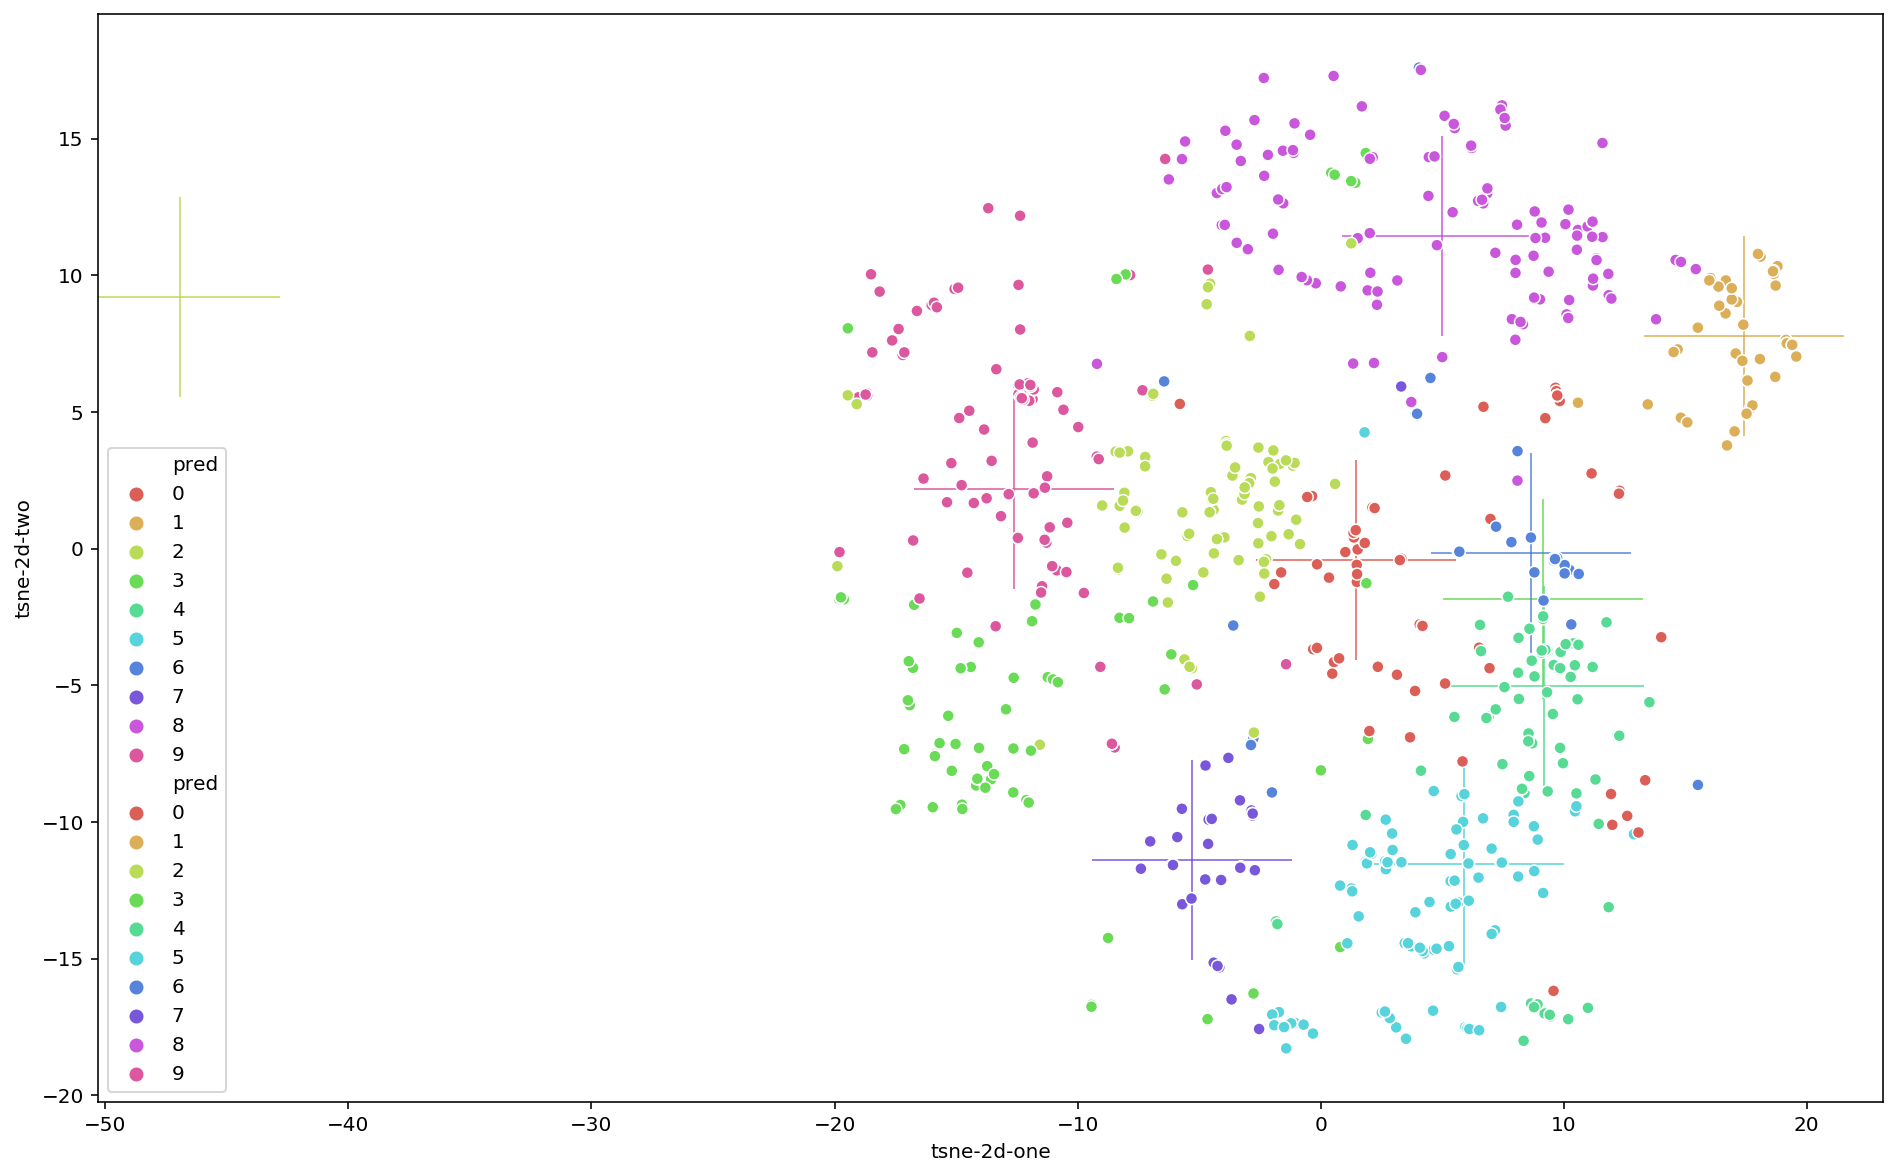

In [25]:
plt.figure(figsize=(16,10))

# plot centroids
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="pred",
    palette=sns.color_palette("hls", true_k),
    data=df2,
    legend="full",
    s=10000,
    marker="+",
    alpha=1.0
);

# plot samples
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="pred",
    palette=sns.color_palette("hls", true_k),
    data=df_subset,
    legend="full",
    alpha=1.0
);